## Gestion des expériences dans MLflow

Dans ce chapitre, nous allons vous donner une expérience pratique des prévisions de stocks en créant différents modèles et en comparant les métriques de différentes exécutions dans MLflow. 

Vous serez guidé sur la façon d'utiliser la méthode d'expérimentation MLflow afin que différents praticiens de l'apprentissage automatique puissent partager des métriques et s'améliorer sur le même modèle. Plus précisément, nous examinerons les sujets suivants dans ce chapitre. :

* Prise en main du module d'expériences
* Dénir l'expérience
* Ajouter des expériences
* Comparer différents modèles
* Ajuster votre modèle avec l'optimisation des hyperparamètres


À ce stade, nous avons actuellement un pipeline de référence qui agit sur la base d'une heuristique naïve. Dans ce chapitre, nous ajouterons à notre ensemble de compétences la possibilité d'expérimenter plusieurs modèles et de régler un modèle spécifique à l'aide de MLflow. Chapitre 2, Votre projet d'apprentissage automatique. 

Dans ce chapitre, nous allons ajouter à notre plate-forme pour comparer plusieurs modèles et exécuter des expériences dans le benchmark afin de pouvoir créer un prédicteur pour un stock et un ticker spécifiques. Dans les fonctions de science des données, une méthodologie commune consiste à développer un modèle pour un modèle spécifique qui implique les trois étapes suivantes : créer des modèles de base avec différents types de modèles, identifier le modèle le plus performant et prédire avec le meilleur modèle.

## Prise en main du module d'expérimentations

Pour débuter avec les modules techniques, vous devrez vous familiariser avec l'environnement préparé pour ce chapitre dans le dossier suivant : https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/tree/master/Chapitre04

Vous devriez être capable, à ce stade, d'exécuter la commande make pour construire votre plan de travail avec les dépendances nécessaires pour suivre ce chapitre. Vous devez ensuite taper la commande suivante pour vous déplacer dans le bon répertoire


    $ cd Chapter04/gradflow/

Pour démarrer l'environnement, vous devez exécuter la commande suivante :


    $ make

  
Le point d'entrée pour commencer à gérer l'expérimentation dans MLflow est l'interface d'expérimentation illustrée à la Figure 4.1 :

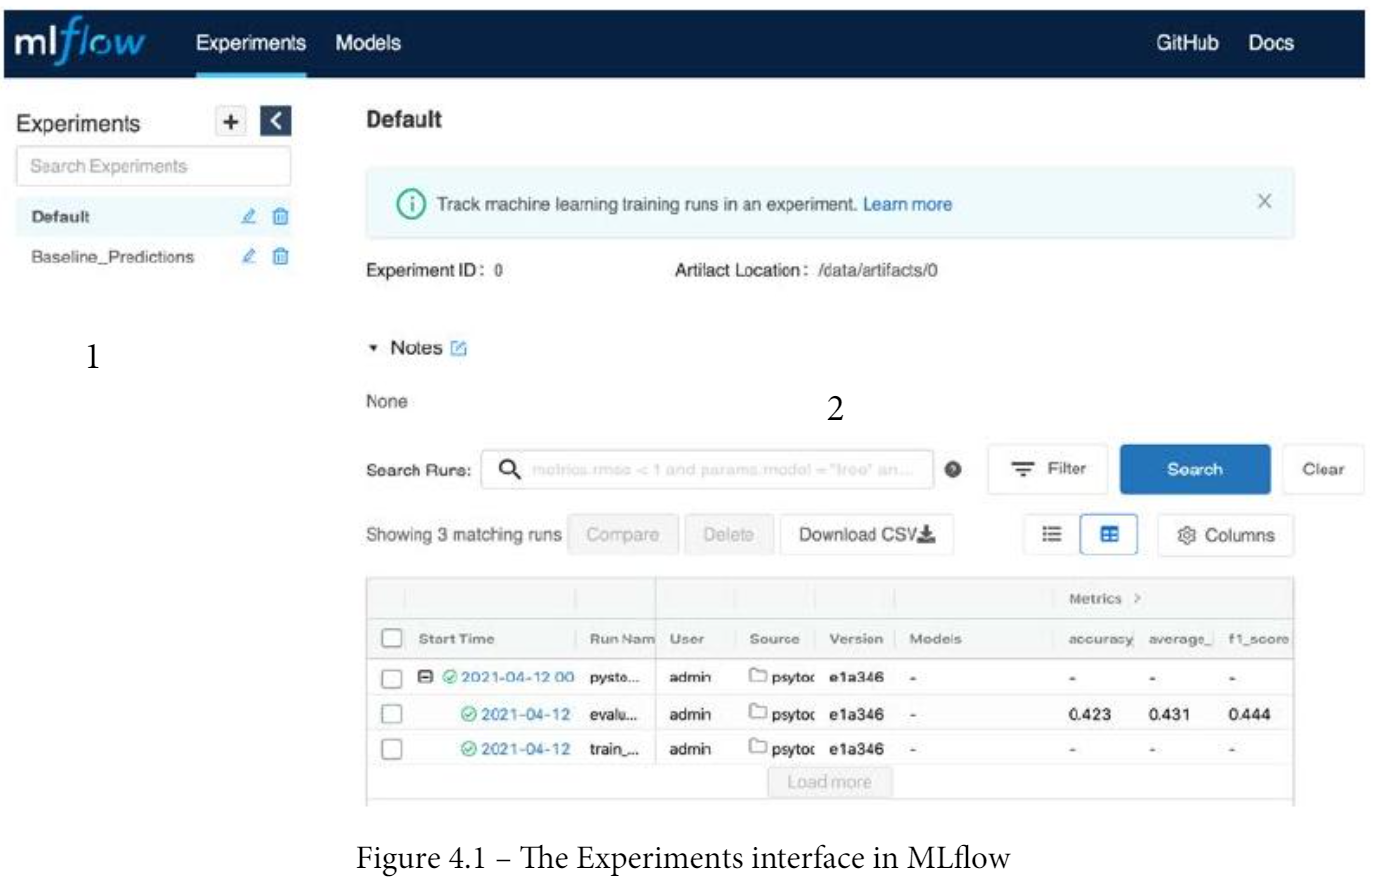

Sur le volet gauche (1), vous pouvez gérer et créer des expériences, et sur la droite (2), vous pouvez interroger les détails d'une expérience spécifique

Pour créer une nouvelle expérience, vous devez cliquer sur le bouton + dans le volet gauche et ajouter les détails de votre expérience, comme illustré par la figure 4.2 :


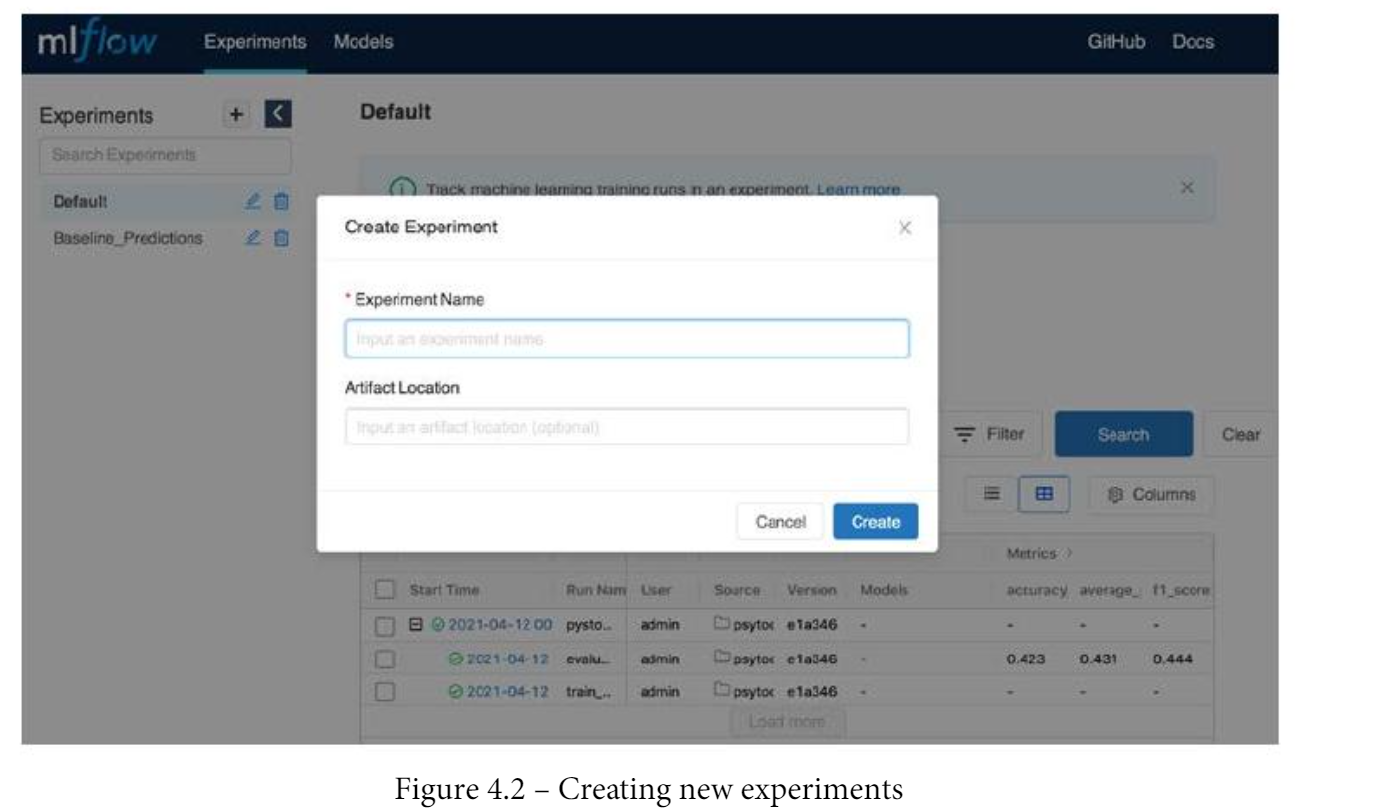

Après avoir introduit à un niveau élevé le serveur de suivi et les fonctionnalités de gestion des expériences, nous allons maintenant utiliser les fonctionnalités disponibles sur notre plan de travail pour relever les défis du chapitre actuel

## Définition de l'expérience

En utilisant la méthodologie de cadrage des problèmes d'apprentissage automatique, nous allons maintenant définir les principaux composants de notre problème de prédiction du cours des actions tel que défini pour le chapitre

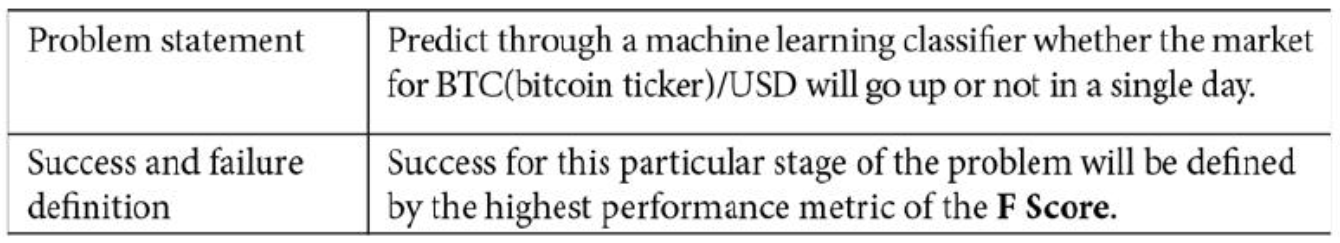

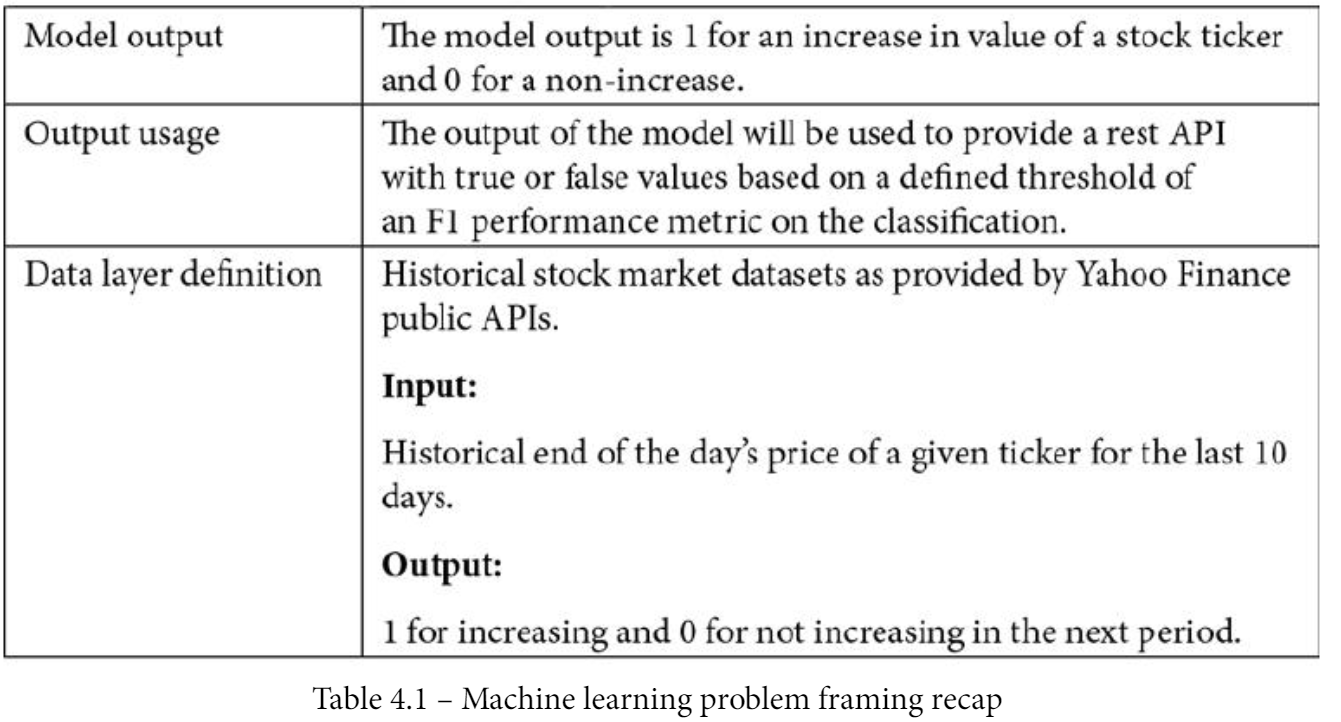



La métrique du score F en apprentissage automatique est une mesure de précision pour les classificateurs binaires et fournit un bon équilibre et un compromis entre les erreurs de classification (faux positifs ou faux négatifs). Plus de détails peuvent être trouvés sur la page Wikipédia : https://en.wikipedia.org/wiki/F-score.

Exploration de l'ensemble de données

Comme spécifié dans notre cadrage des problèmes d'apprentissage automatique, nous utiliserons comme données d'entrée les observations du marché pour la période janvier-décembre 2020, telles que fournies par l'API de données Yahoo. 

L'extrait de code suivant, qui utilise le module pandas_datareader disponible dans notre workbench, nous permet de récupérer facilement les données que nous voulons. Le cahier de travail complet est disponible sur https://github.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/blob/master/Chapter04/gradflow/notebooks/retrieve_training_data.ipynb

In [ ]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import requests
from matplotlib import pyplot as plt

 #Workaround to handle issue https://github.com/pydata/pandas-datareader/issues/868
USER_AGENT = {
    'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'
                ' Chrome/91.0.4472.124 Safari/537.36')
    }
sesh = requests.Session()
sesh.headers.update(USER_AGENT)


start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)

btc_df = web.DataReader("BTC-USD", 'yahoo', start, end,  session=sesh)
btc_df

High           Low  ...       Volume     Adj Close
Date                                    ...                           
2014-09-17    468.174011    452.421997  ...     21056800    457.334015
2014-09-18    456.859985    413.104004  ...     34483200    424.440002
2014-09-19    427.834991    384.532013  ...     37919700    394.795990
2014-09-20    423.295990    389.882996  ...     36863600    408.903992
2014-09-21    412.425995    393.181000  ...     26580100    398.821014
...                  ...           ...  ...          ...           ...
2020-12-28  27389.111328  26207.640625  ...  49056742893  27084.808594
2020-12-29  27370.720703  25987.298828  ...  45265946774  27362.437500
2020-12-30  28937.740234  27360.089844  ...  51287442704  28840.953125
2020-12-31  29244.876953  28201.992188  ...  46754964848  29001.720703
2021-01-01  29600.626953  28803.585938  ...  40730301359  29374.152344

[2299 rows x 6 columns]

Pour ce problème particulier, nous récupérerons les données de 2014 jusqu'à la fin de 2020, comme représenté dans le tableau fourni à la figure 4.3. Le tableau fournit des informations sur la valeur High, Low, Open et Close pour l'action BTC de la section de négociation. Ces données seront utilisées pour entraîner les modèles dans le chapitre actuel

Ces données peuvent facilement être tracées en traçant l'une des variables juste pour illustrer la nature continue des données :

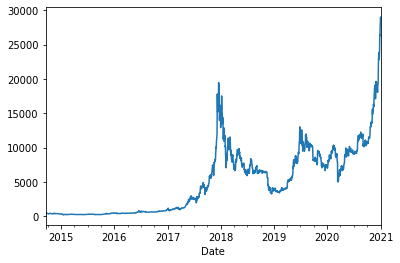

In [ ]:
btc_df['Open'].plot()
resolution_value = 1200
plt.savefig("myImage.png", format="png", dpi=resolution_value)

Après avoir défini précisément ce que nous allons expérimenter dans cette section, nous allons ajouter de nouveaux modèles pour nous permettre d'exécuter des expériences et de les comparer. Les données pour la plage requise ont été enregistrées de manière pratique dans un fichier sous le chapitre 04/ gradflow/notebooks/training_data.csv, pour la période allant de 2014 à 2020 inclus, afin qu'il puisse être facilement récupéré lors de la phase de modélisation

## Ajout d'expériences 

Ainsi, dans cette section, nous utiliserons le module d'expériences de MLflow pour suivre les différentes exécutions de différents modèles et les publier dans notre base de données d'atelier afin que les résultats de performance puissent être comparés côte à côte. les expériences peuvent en fait être effectuées par différents développeurs de modèles tant qu'ils pointent tous vers une infrastructure MLflow partagée Pour créer notre premier, nous choisirons un ensemble de familles de modèles et évaluerons notre problème sur chacun des cas. En termes plus généraux, les grandes familles de classification peuvent être des modèles arborescents, des modèles linéaires et des réseaux de neurones. 

En examinant la métrique la plus performante dans chacun des cas, nous pouvons ensuite régler directement le meilleur modèle et l'utiliser comme modèle initial en production.Notre choix pour cette section comprend les éléments suivants :

* Classificateur logistique : partie de la famille des modèles linéaires et une ligne de base couramment utilisée.

* Xgboost : il appartient à la famille des algorithmes de renforcement des arbres où de nombreux classificateurs d'arbres faibles sont assemblés pour produire un modèle plus fort. 

* Keras : Ce type de modèle appartient à la famille des réseaux de neurones et est généralement indiqué pour les situations où il y a beaucoup de données disponibles et les relations ne sont pas linéaires entre les caractéristiques


Les étapes de configuration d'un nouveau modèle sont assez courantes et le code se chevauchera et se répétera pour chacun des modèles. Nous commencerons ensuite par un classificateur basé sur la régression logistique

## Étapes de mise en place d'un classificateur basé sur la logistique 

Dans cette sous-section, nous allons implémenter un classificateur de régression logistique dans scikit-learn et entraîner un modèle avec nos données d'entrée. référentiel et peut être utilisé pour suivre dans le Chapter04/gradflow/notebooks/mlflow_run_logistic_regression.ipynb :

1. Importation de dépendances : cette section contient les dépendances les plus importantes, en dehors des dépendances fondamentales (pandas, NumPy et MLflow), dont nous avons besoin pour importer le modèle SKLearn, LogisticRegression, et la fonctionnalité de métriques, f1_score, qui nous permettra pour calculer les performances :

In [ ]:
#! pip install mlflow

In [ ]:
import pandas
import numpy as np
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

2. Configuration des données d'entraînement : les données sont lues à partir du fichier training_data.csv :

In [ ]:
pandas_df = pandas.read_csv("https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-Engineering-with-MLflow/master/Chapter04/gradflow/notebooks/training_data.csv")
X=pandas_df.iloc[:,:-1]
Y=pandas_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=4284, stratify=Y)

Les données sont divisées en formation et test à l'aide de la fonction train_test_split, qui prend un tiers des données pour le test, le reste étant utilisé pour la formation.

3. Configuration de l'expérience : pour définir l'expérience dans MLflow par programmation, vous utilisez la méthode mlflow.set_experiment. Cela créera une expérience si elle n'existe pas ou associera votre exécution actuelle à une expérience. Nous utilisons mlflow.sklearn.autolog() pour activer les capacités automatisées de MLflow afin de capturer les métriques de notre expérience :

In [ ]:
mlflow.set_experiment("Baseline_Predictions")
mlflow.sklearn.autolog()

2021/12/24 17:47:24 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_Predictions' does not exist. Creating a new experiment.


4. Exécution de l'expérience : pour exécuter votre expérience, vous devrez l'inclure dans une exécution à l'aide du mot-clé scope, with. La fonction mlflow.start_run est utilisée pour s'occuper d'enregistrer votre run avec un run_name spécifique afin qu'il puisse être identifié et enferme le modèle d'ajustement, avec le code d'évaluation utilisé pour calculer les métriques de performance de l'expérience f1_score :

In [ ]:
model = LogisticRegression()
with mlflow.start_run(run_name='logistic_regression_model_baseline') as run:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    y_pred = np.where(preds>0.5,1,0)
    f1 = f1_score(y_test, y_pred)
    mlflow.log_metric(key="f1_experiment_score", value=f1)

2021/12/24 17:47:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2021/12/24 17:47:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator."
2021/12/24 17:47:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecatio

De plus, nous devons enregistrer notre métrique spécifique, f1_experiment_score, avec la fonction mlflow.log_metric. La principale raison pour laquelle nous avons ajouté notre méthode spécifique est que pour chaque modèle, la fonctionnalité de journalisation automatique dans MLflow utilise la métrique par défaut utilisée par chaque framework sous-jacent et généralement, ces métriques ne correspondent pas

Après avoir exécuté toutes les étapes relatives au développement du modèle, nous pouvons maintenant naviguer jusqu'à notre exécution et visualiser le journal de l'expérience. Dans la figure 4.5, vous pouvez voir les paramètres spéciques associés à la régression logistique, les durées et tous les paramètres utilisés sur votre analyse :

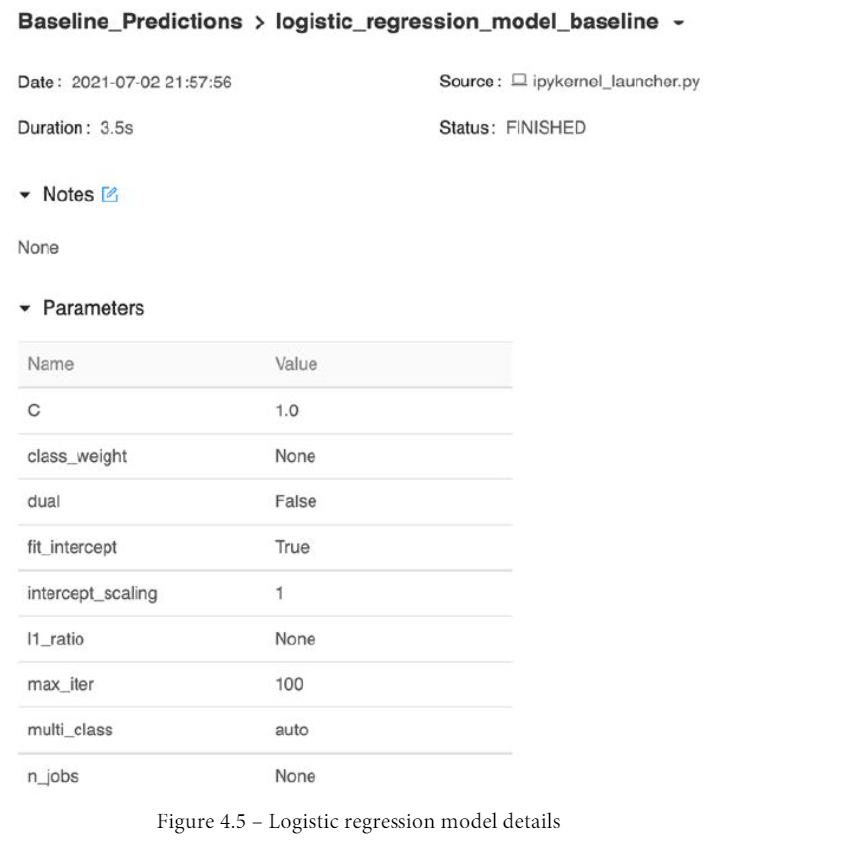

Pour les modèles SKLearn, MLflow enregistre automatiquement les matrices de confusion et les courbes de précision et de rappel qui sont très utiles pour détecter les performances du modèle sur les données d'entraînement. Par exemple, le rapport de la figure 4.6 sera stocké dans les artefacts de votre exécution :

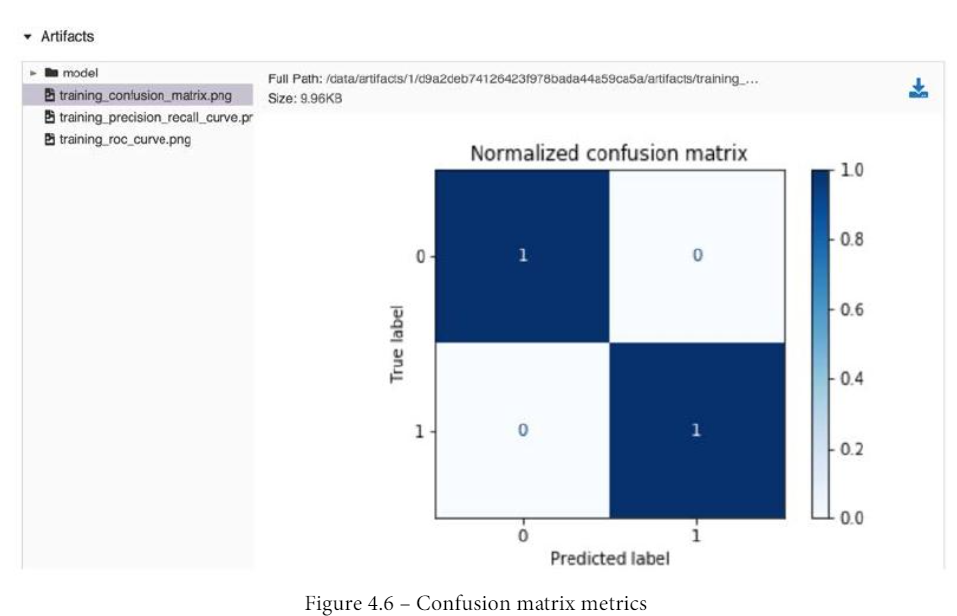

MLflow fournit des métriques intégrées pour Sklearn, offrant une meilleure visibilité du modèle produit pendant la formation sans que le développeur ait besoin de produire du code supplémentaire.


## Étapes de configuration d'un classificateur basé sur XGBoost

Nous allons maintenant implémenter un algorithme basé sur un arbre de gradient à l'aide de la bibliothèque XGBoost. Le cahier complet pour ce modèle est disponible dans le référentiel du livre et peut être utilisé pour suivre le chapitre04/gradflow /notebooks/mlflow_run_xgboost.ipynb le :Importation des dépendances : la bibliothèque XGBoost est importée avec la fonction de métrique :

In [ ]:
import pandas
import mlflow
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

1. Récupération des données : cette étape reste la même pendant que nous divisons les données et lisons les données du fichier training_data.csv

2. Configuration de l'expérience : l'expérience est toujours la même, Baseline_Predictions, et nous devons donner à MLflow l'instruction d'enregistrer automatiquement le modèle via mlflow.xgboost.autolog :

In [ ]:
mlflow.set_experiment("Baseline_Predictions")
mlflow.xgboost.autolog()


3. Exécution de l'expérience : cette expérience est très similaire au cas précédent où nous exécutons le modèle et évaluons les métriques via f1_score :

In [ ]:
dtrain=xgb.DMatrix(X_train, y_train)
dtest=xgb.DMatrix(X_test, y_test)
threshold = 0.5
with mlflow.start_run(run_name='xgboost_model_baseline') as run:
    model=xgb.train(dtrain=dtrain,params={})
    preds = model.predict(dtest)
    y_bin = [1. if y_cont > threshold else 0. for y_cont in preds]
    f1= f1_score(y_test,y_bin)
    mlflow.log_metric(key="f1_experiment_score", value=f1)

Après avoir exécuté toutes les étapes relatives au développement du modèle, nous pouvons maintenant naviguer jusqu'à notre exécution et visualiser le journal de l'expérience. Dans la figure 4.7, vous pouvez voir les paramètres spéciques associés à xgboost_model_baseline, les durées et tous les paramètres utilisés lors de votre exécution :

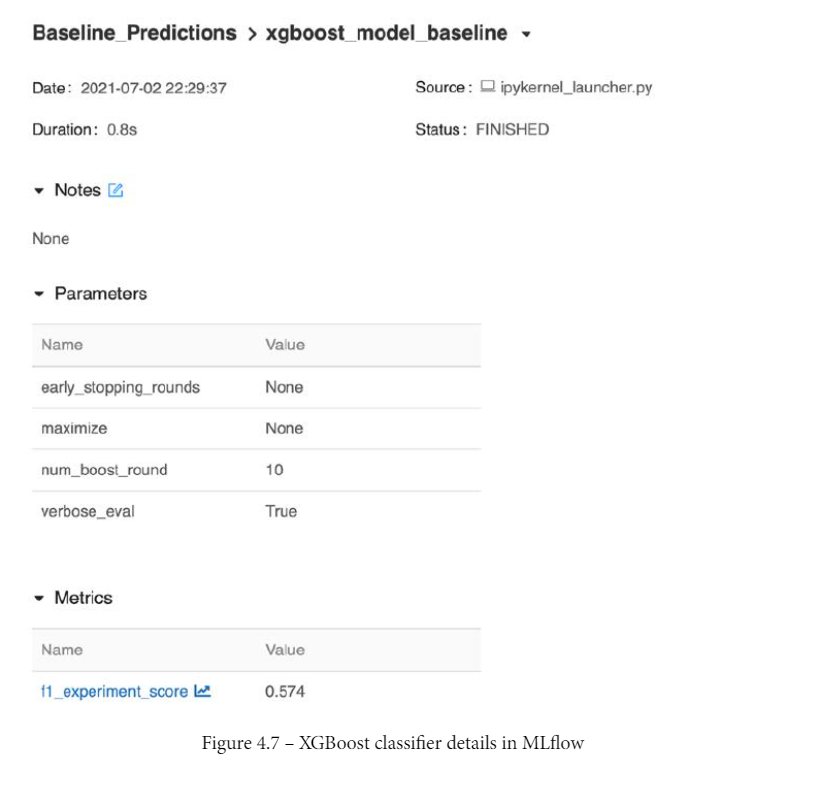

Pour les modèles XGBoost, MLflow enregistre automatiquement les informations et l'importance des fonctionnalités. Nous pouvons voir sur la Figure 4.8 le classement de nos fonctionnalités dans le modèle stocké dans la section Artefacts de l'atelier :

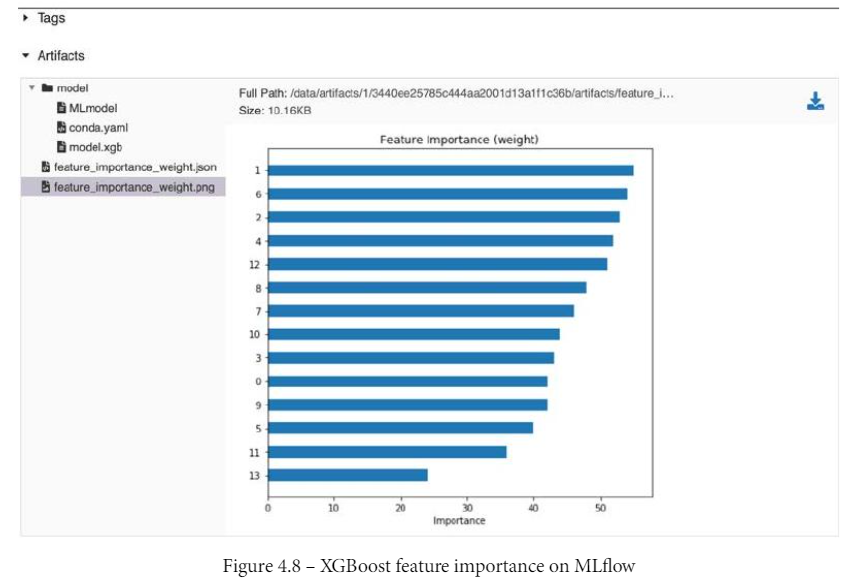

Le graphique d'importance des caractéristiques de la figure 4.8 permet au développeur d'avoir un aperçu des éléments internes du modèle déterminés à partir des données. Dans ce cas particulier, il semble que les deuxième et septième jours des 14 jours du vecteur d'entrée soient les deux principales caractéristiques significatives. Nous allons ensuite implémenter un modèle basé sur l'apprentissage en profondeur.

## Étapes de configuration d'un classificateur basé sur l'apprentissage en profondeur 

Dans cette section, nous allons implémenter un algorithme de réseau de neurones pour résoudre notre problème de classification


Le ficahier complet de ce modèle est disponible dans le référentiel du guide et peut être utilisé pour suivre dans le chapitre 04/gradflow/notebooks/mlflow_run_keras.ipynb le:

1. Importation de dépendances : la dépendance principale de cette étape est tensorflow, car nous l'utilisons comme backend pour keras :

In [ ]:
import pandas
import numpy as np
import mlflow
import tensorflow
from tensorflow import keras
import mlflow.keras
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

2. Récupération des données : reportez-vous à l'étape 2 de la section Étapes de configuration d'un classificateur basé sur XGBoost.

3. Configuration de l'expérience : l'expérience est toujours la même, Baseline_Predictions, et nous devons donner à MLflow l'instruction d'enregistrer automatiquement le modèle via mlflow.tensorflow.autolog :

In [ ]:
mlflow.set_experiment("Baseline_Predictions")
mlflow.tensorflow.autolog()

Création du modèle : L'une des grandes différences par rapport au modèle basé sur les neurones est que la création du modèle est un peu plus complexe que les classificateurs Sklearn ou XGBoost, nous devons donc dénir les couches et l'architecture de le réseau. Dans ce cas particulier, l'architecture séquentielle et le modèle doivent être compilés comme requis par Tensorflow :

In [ ]:
model = keras.Sequential([
  keras.layers.Dense(
    units=36,
    activation='relu',
    input_shape=(X_train.shape[-1],)
  ),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(units=1, activation='sigmoid'),
])

model.compile(
  optimizer=keras.optimizers.Adam(lr=0.001),
  loss="binary_crossentropy",
  metrics="Accuracy"
)

4. Exécution du modèle : l'exécution du modèle implique les mêmes étapes que la spécification de run_name et l'ajustement du modèle suivi du calcul des métriques f1_score :

In [ ]:
with mlflow.start_run(run_name='keras_model_baseline') as run:
    model.fit(
        X_train,
        y_train,
        epochs=20,
        validation_split=0.05,
        shuffle=True,
        verbose=0
    )
    preds = model.predict(X_test)
    y_pred = np.where(preds>0.5,1,0)
    f1 = f1_score(y_test, y_pred)
    mlflow.log_metric(key="f1_experiment_score", value=f1)


Pour les modèles Keras, MLflow enregistre automatiquement une myriade de données liées au réseau de neurones, à savoir, concernant les optimiseurs et les tailles d'époque et de lot, ainsi que d'autres informations pertinentes qui peuvent être vues dans la Figure 4.9 :

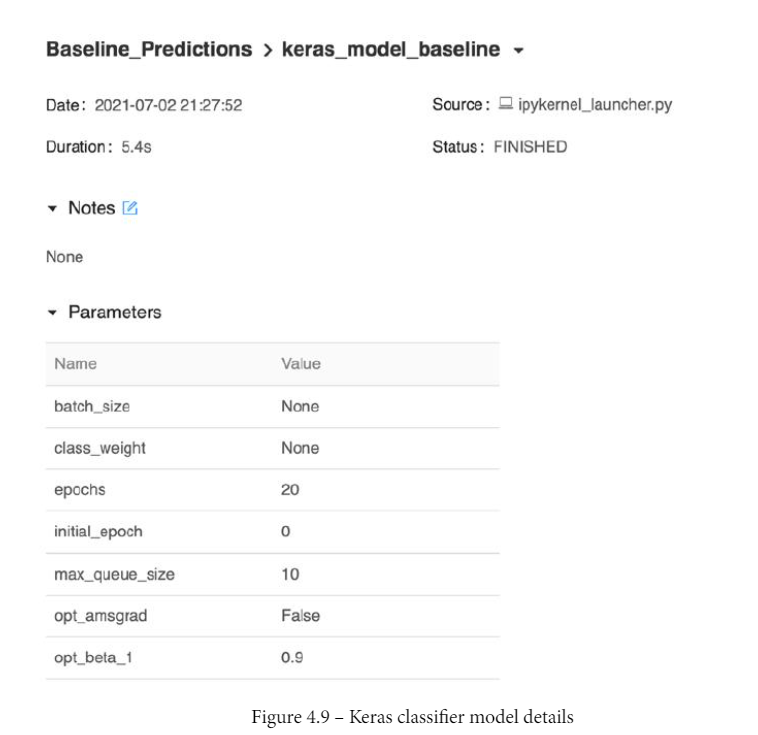

De plus, les journaux TensorFlow peuvent être connectés à un TensorBoard. Il s'agit d'un outil intégré TensorFlow qui fournit des visualisations et des métriques pour le flux de travail d'apprentissage automatique. Des interfaces sont créées pour que le développeur de modèles puisse tirer parti de l'instrumentation native TensorFlow et des outils de visualisation spécialisés. Après avoir configuré nos classificateurs dans notre plate-forme, dans la section suivante, nous sommes prêts à comparer les performances des différents classificateurs développé à l'aide de MLflow.

## Comparer différents modèles 

Nous avons mené les expériences de cette section pour chacun des modèles couverts et vérifié tous les différents artefacts. En examinant simplement notre tableau d'expérience de base et en sélectionnant la métrique personnalisée commune, f1_experiment_score, nous pouvons voir que le modèle le plus performant est le modèle basé sur la régression logistique, avec un F-score de 0,66 :

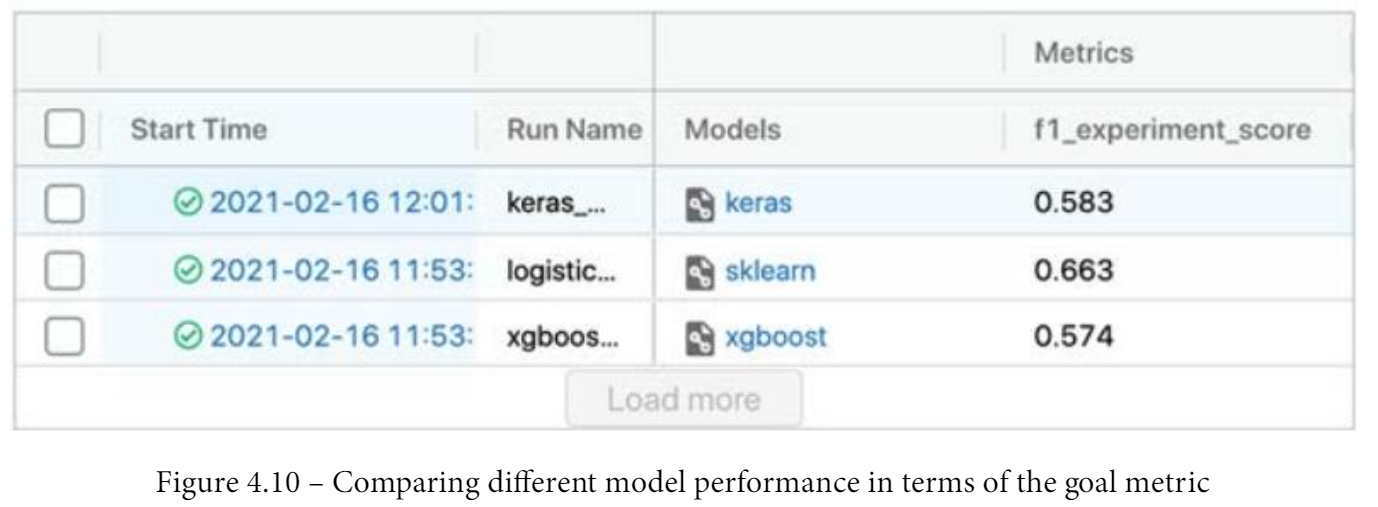

Les mesures peuvent également être comparées côte à côte, comme le montre l'extrait de la figure 4.11. À gauche, nous avons le modèle SKlearn, et à droite le modèle XGBoost, avec les métriques personnalisées de f1_experiment_score. Nous pouvons voir que les métriques fournies par les deux sont différentes et, par conséquent, la raison des métriques personnalisées lorsque nous avons des modèles différents :


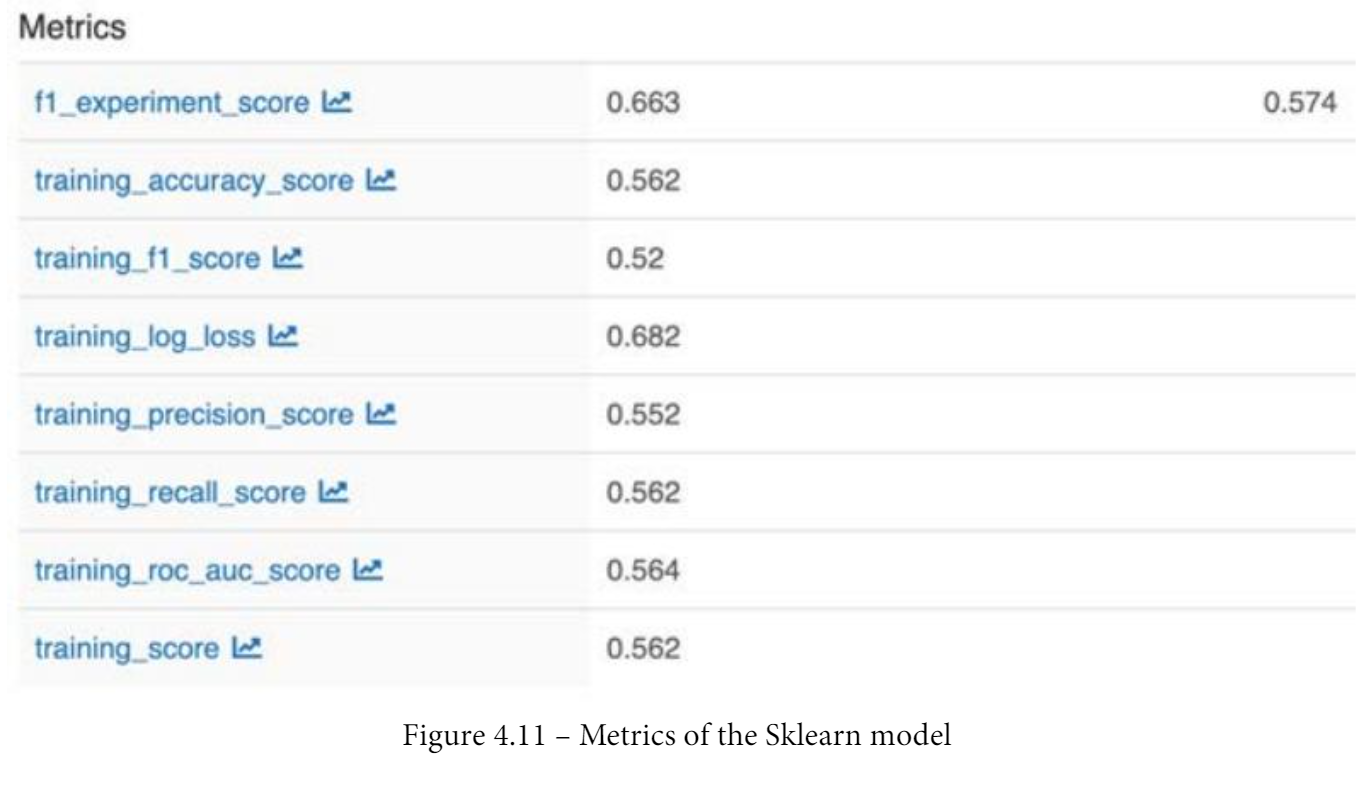

Après avoir comparé les métriques, il devient clair que le meilleur modèle est la régression logistique. Pour améliorer le modèle, dans la section suivante, nous optimiserons ses paramètres avec des techniques de pointe et utiliserons les fonctionnalités de l'expérience MLflow pour y parvenir

## Réglage de votre modèle avec l'optimisation des hyperparamètres 

Les modèles d'apprentissage automatique ont de nombreux paramètres qui permettent au développeur d'améliorer les performances et de contrôler le modèle qu'il utilise, fournissant ainsi un levier pour mieux adapter les données et les cas d'utilisation de production. 

L'optimisation des hyperparamètres est le processus systématique et automatisé d'identification des paramètres optimaux pour votre modèle d'apprentissage automatique et est essentielle au déploiement réussi d'un tel système. 

Dans la section précédente, nous avons identifié le meilleur modèle de famille (en d'autres termes, LogisticRegression) pour notre problème, il est donc maintenant temps d'identifier les bons paramètres pour notre modèle avec MLflow. Vous pouvez suivre dans le bloc-notes suivant dans le référentiel du projet, Chapter04/gradflow/notebooks/hyperopt_optimization_logistic_regression_mlflow.ipynb:1. Importation de dépendances : nous utiliserons la bibliothèque hyperopt, qui contient plusieurs algorithmes pour nous aider à effectuer le réglage du modèle :

In [ ]:
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas
import mlflow

2. Dénir une fonction objectif : la fonction objectif est l'étape la plus importante du processus, définissant essentiellement ce que nous voulons atteindre avec notre optimisation. 

Dans notre cas particulier, nous souhaitons optimiser la métrique f1_score dans notre modèle. La façon dont l'optimisation fonctionne dans hyperopt passe par la minimisation, mais dans notre cas, nous voulons la métrique f1_score maximale possible. Ainsi, la façon dont nous définissons notre perte (la fonction à minimiser) est l'inverse de notre métrique f1_score, comme dans loss = 1-fscore, donc la minimisation de cette fonction représentera la meilleure métrique f1_score. Pour chaque exécution des paramètres du modèle, nous l'enfermerons dans un mlflow.start_run(nested=True) de manière à ce que chaque itération d'optimisation soit enregistrée en tant que sous-exécution de la tâche principale, offrant de multiples avantages en termes de comparaison de métriques à travers les pistes :

In [ ]:
N_FOLDS = 4
MAX_EVALS = 10

def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC
    mlflow.sklearn.autolog()
    with mlflow.start_run(nested=True):
        clf = LogisticRegression(**params,random_state=0,verbose =0)
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')

        # Extract the best score
        best_score = max(scores)

        # Loss must be minimized
        loss = 1 - best_score

        # Dictionary with information for evaluation
        return {'loss': loss, 'params': params, 'status': STATUS_OK}

3. Exécution d'essais d'optimisation : L'étape d'essais nous permet d'exécuter plusieurs expériences avec l'algorithme de régression logistique et nous aide à identifier la meilleure configuration possible pour notre modèle, qui sera stockée sous la meilleure variable. La fonction de base est la minimisation représentée par fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trial = bayes_trials), où nous fournissons l'espace des paramètres et la fonction objectif tels que définis précédemment :




In [ ]:
space = {
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    'C' : hp.uniform('C', 0.05, 3),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

In [ ]:
mlflow.set_experiment("Hyperopt_Optimization")

# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()




with mlflow.start_run():
    best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

4. Après avoir exécuté l'expérience pendant quelques minutes, nous pouvons maintenant revoir les expériences dans MLflow. La figure 4.12 représente l'expérience et la hiérarchie imbriquée des multiples expériences exécutées sous l'égide de l'expérience Hyperopt_Optimization :

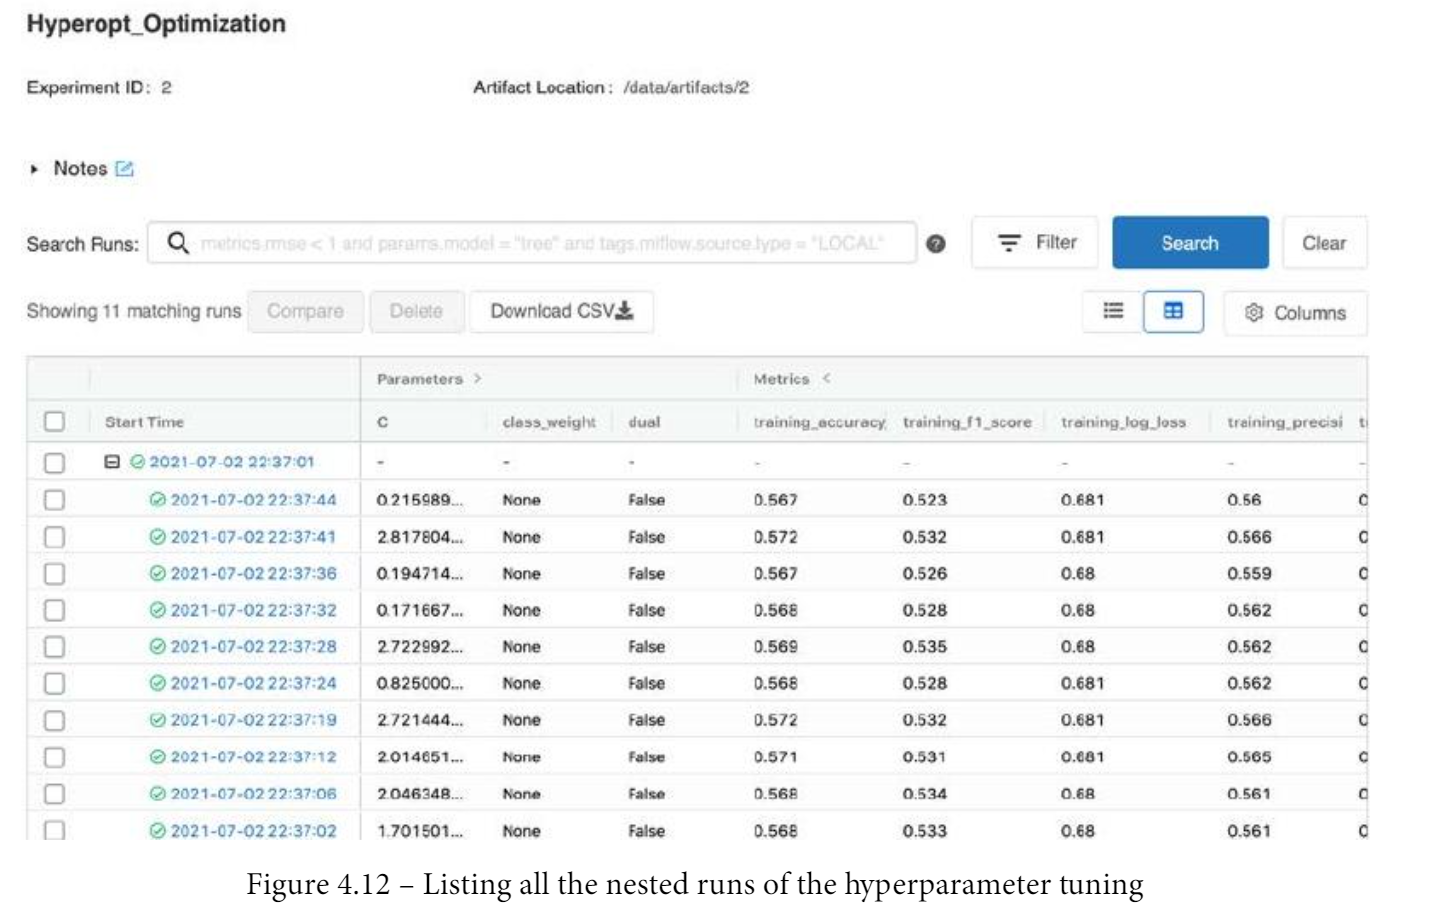

5. En cliquant sur l'option de comparaison, nous avons les résultats affichés dans la Figure 4.13. Vous pouvez analyser plusieurs exécutions de l'optimisation des paramètres en séquence, en examinant l'implication de paramètres spécifiques par rapport aux métriques de performance telles que training_f1_score et le solveur


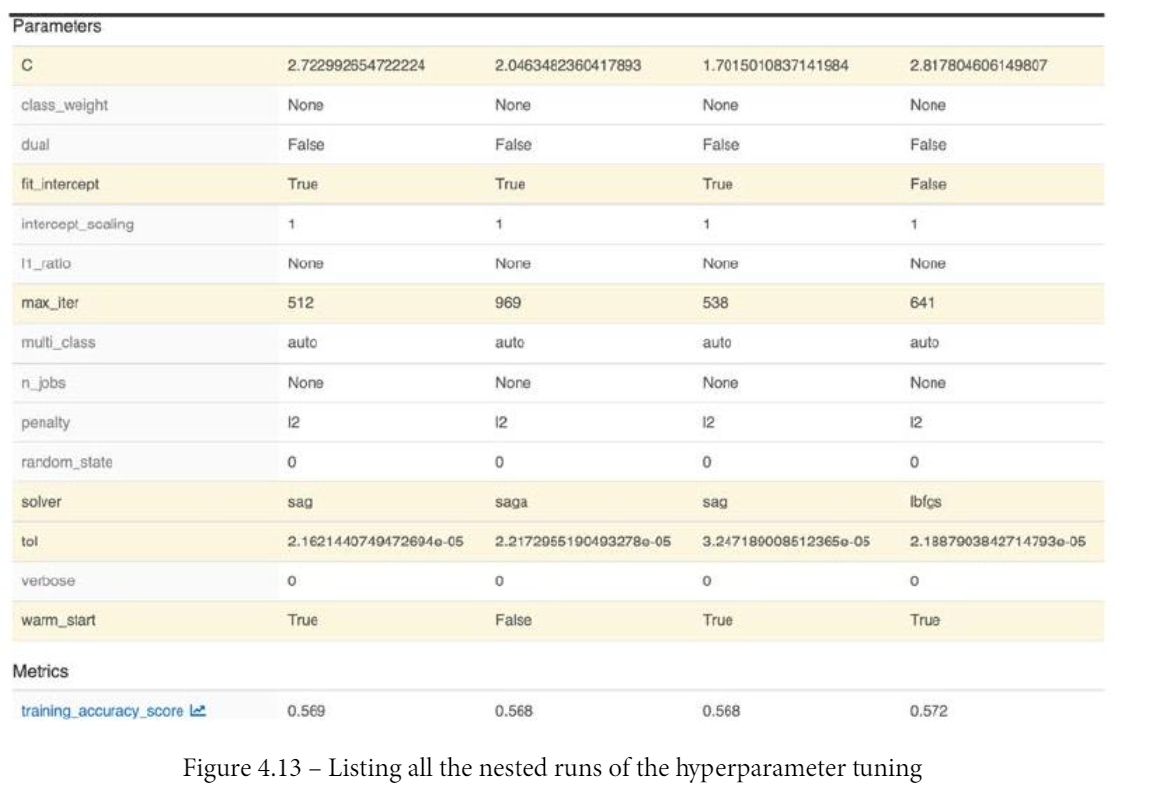

6. Nous pouvons facilement comparer dans la même interface les différents solveurs et implications pour notre métrique de performance, fournissant des informations supplémentaires sur notre phase de modélisation :

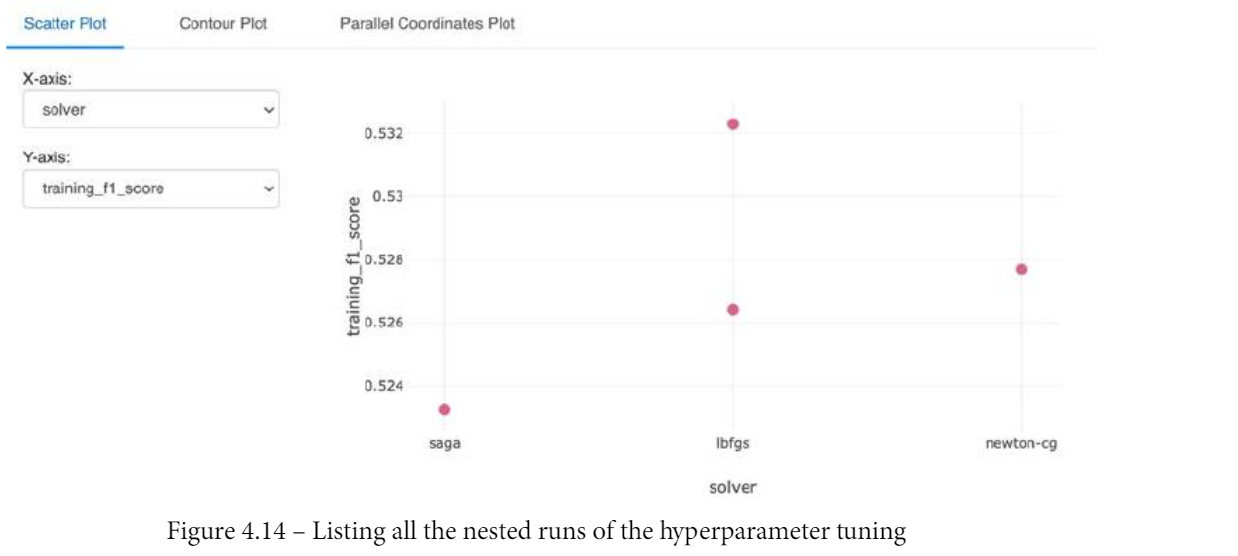

Nous avons conclu cette section en optimisant les paramètres du modèle le plus performant pour notre problème actuel. Dans le prochain chapitre du livre, nous utiliserons les informations fournies par le meilleur modèle pour approfondir le cycle de vie de la gestion des modèles dans MLflow